<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Information-Bottleneck-for-Decision-Trees" data-toc-modified-id="Information-Bottleneck-for-Decision-Trees-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Information Bottleneck for Decision Trees</a></span><ul class="toc-item"><li><span><a href="#Proposal" data-toc-modified-id="Proposal-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Proposal</a></span></li><li><span><a href="#Implementation-of-the-algorithm" data-toc-modified-id="Implementation-of-the-algorithm-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Implementation of the algorithm</a></span></li><li><span><a href="#IB-Tree-estimator-properties:-consitency-and-bias" data-toc-modified-id="IB-Tree-estimator-properties:-consitency-and-bias-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>IB Tree estimator properties: consitency and bias</a></span></li><li><span><a href="#Generalization:-IB-and-VC-dimension" data-toc-modified-id="Generalization:-IB-and-VC-dimension-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Generalization: IB and VC dimension</a></span></li></ul></li><li><span><a href="#Visualizations" data-toc-modified-id="Visualizations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Visualizations</a></span><ul class="toc-item"><li><span><a href="#Effect-of-Regularization" data-toc-modified-id="Effect-of-Regularization-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Effect of Regularization</a></span></li><li><span><a href="#Capacity-of--a-tree" data-toc-modified-id="Capacity-of--a-tree-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Capacity of  a tree</a></span></li><li><span><a href="#Growing-a-Tree" data-toc-modified-id="Growing-a-Tree-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Growing a Tree</a></span><ul class="toc-item"><li><span><a href="#Densely-sampled-(completely-unrealistic,-but-interesting)" data-toc-modified-id="Densely-sampled-(completely-unrealistic,-but-interesting)-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Densely sampled (completely unrealistic, but interesting)</a></span></li></ul></li><li><span><a href="#Same,-but-X-is-randomly-sampled-(a-bit-closer-to-the-real-world)" data-toc-modified-id="Same,-but-X-is-randomly-sampled-(a-bit-closer-to-the-real-world)-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Same, but X is randomly sampled (a bit closer to the real world)</a></span></li></ul></li><li><span><a href="#Real-world-experiment" data-toc-modified-id="Real-world-experiment-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Real world experiment</a></span><ul class="toc-item"><li><span><a href="#Iris-Flower-Data" data-toc-modified-id="Iris-Flower-Data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Iris Flower Data</a></span></li><li><span><a href="#MNIST" data-toc-modified-id="MNIST-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>MNIST</a></span></li></ul></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2
from ibtree import *
from ibtree.datasets import easy_data, caro_data, circle_data, circle_y, grid2d
from ibtree.visualize import *

import ipywidgets as widgets
from IPython.display import display, HTML

javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}


def toggle_code(state):

    """
    Toggles the JavaScript show()/hide() function on the div.input element.
    """

    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)

    display(HTML(output))


def button_action(value):

    """
    Calls the toggle_code function and updates the button description.
    """

    state = value.new

    toggle_code(state)

    value.owner.description = button_descriptions[state]


state = False
toggle_code(state)

button = widgets.ToggleButton(state, description = button_descriptions[state])
button.observe(button_action, "value")

display(button)


ToggleButton(value=False, description='Show code')

# Information Bottleneck for Decision Trees

## Proposal
Decision trees are a class of machine learning algorithms that can be used for classification and regression problems. From an information theoretical perspective, they can be viewed as algorithms to construct optimal binary encodings $e: \mathcal{X} \mapsto \mathcal{B} $ for $\mathcal{B}$ being the set of binary words, and $\mathcal{X}$ being data sampled of an unkown distribution $P_X : \mathcal{X} \mapsto [0, 1]$.
It is interesting to analyze this in the information bottleneck framework (IB), which gives a justification to expect generalization.

Specifically, the following questions shall be answered:
- can we use decision trees to efficiently optimize for the IB objective? What is the time and space complexity of such an implementation?
- for which distributions $P_{X,Y}$ or probability densities $p_{X,Y}$ does this lead to a consistent unbiased estimator and for which distributions does it lead to a suboptimal estimator?
- What is the VC dimension of this algorithm? Can we find generalization bounds?
- How does this algorithm perform on different toy and real world datasets in comparison to other decision trees? How does a gradient boosted ensemble of these decision trees perform on a real world dataset, compared to a regular xgboost model?
- In the original IB paper, the authors propose the The information bottleneck iterative algorithm. How does it compare to IB trees?

## Implementation of the algorithm

The IB objective is given as
$$ J'(e) = \beta I(X, e(X)) - I(e(X), y)  = \beta ( H(X) - H(X|e(X) ) - H(y) + H(y|e(X)) $$
If we ignore all terms independent of $e$, we get:
$$ J(e) =  H(y|e(X)) - \beta H(X|e(X)) $$

It is straight forward to apply the IB method to decision trees. The first term  $H(y|e(X))$ is a widely used objective in decision trees, and the second term $\beta H(X|e(X))$ serves as a regularizer. 

In the fitting phase, the IB tree tries to find a binary split $f(x) = x_i > t$ such that $J(f)$ is minimal. If the optimal split is a constant function over the samples, all points are grouped into the same split and the (sub)tree is a leaf. In this way, pruning is no longer necessary.

The loss function for a non-leaf tree can be expressed as:


$$  J = H(y|e(X)) - \beta H(X|e(X)) $$
$$ = \sum_{i=0}^1 ( P(e(X)=i) * (H(y|e(X)=i) - \beta H(X|e(X)=i)) ) $$
$$ = P(e(X)=0) * J(left) + P(e(X)=1) * J(right) $$

The loss of a leaf is simply:

$$    J = H(y|e(X)) - \beta H(X|e(X)) $$
$$      = H(y) - \beta H(X) $$

To estimate $H(X)$, we simply assume a uniform distribution over all samples, i.e. $log(N)$.

This allows an efficient recursive computation of the loss.



## IB Tree estimator properties: consitency and bias
Notes:
- This is definitely not in general a consistent estimator: examples where the algorithm fails to converge to a good solution is given in the experimental section (caro data).
- This estimator also has a bias, since it can only express decision boundaries of the type ${x : \bigwedge\limits_{i=1}^{depth} x_i = t_i$} $ (see experiments) - it cannot accurately represent a circle and favors squared shapes in the absence of sufficient samples
- An interesting subclass of distributions are those that can be expressed perfectly by a decision tree of limited size
    - even there, the greedy optimization may get stuck in local optima (caro data problem)
    - but good news is that for most distrubitions that can be expressed, the caro data problem does not occur

## Generalization: IB and VC dimension
An upper bound for the VC dimension of a decision tree is $2^{#leaves}$.
- Given $N, \beta$, what is the VC dimension of an IB tree? Can we find an upper bound for $I(X, e(X)) \leq \psi(D)$?
- What is the implied generalization bound?

# Visualizations

## Effect of Regularization

For these toy datasets, we consider the very first split - and plot the loss as function of the threshhold.
We observe:
- Adding regularizations by using the IB loss favors splits of uneven size.
- If the data is symmetric in two axis, we get the same graph for both axes.
- The greedy optimization fails in the last case to do the very first split, independent of regularization

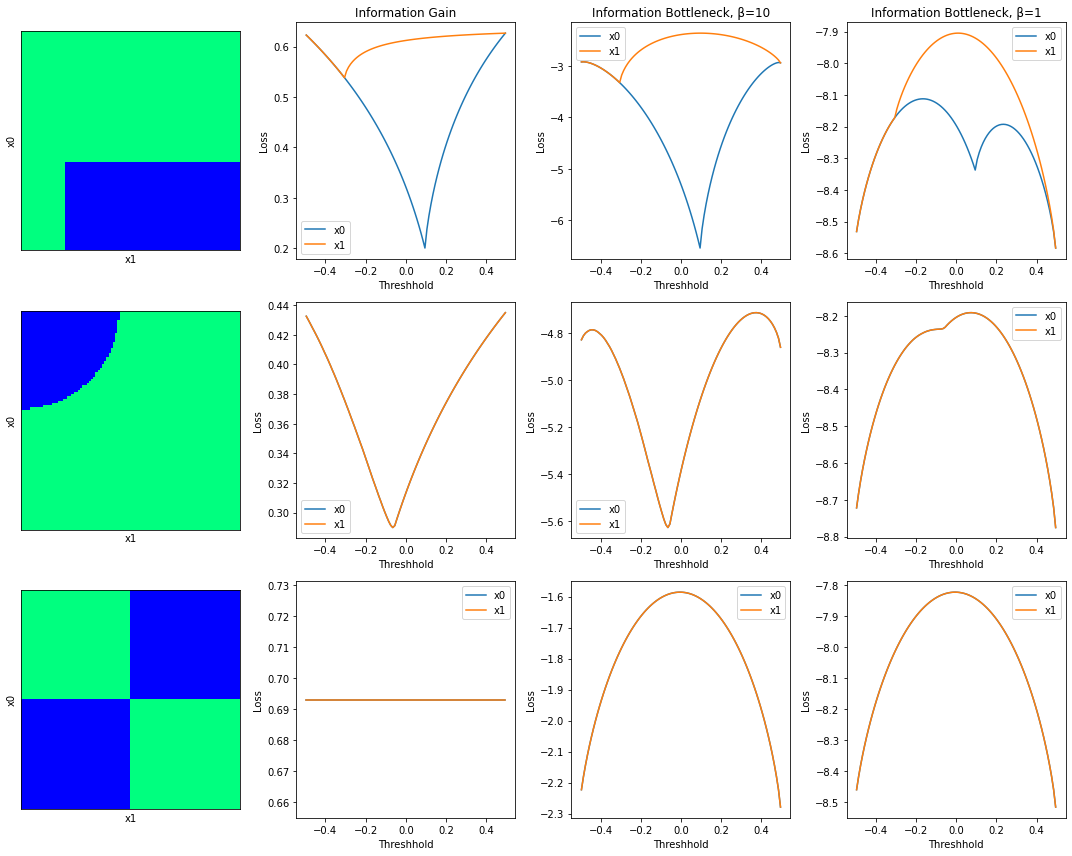

In [55]:
plt.figure(figsize=(15,12))

plt.subplot(341)
X, y = easy_data()
plot_on_grid(y[:,0], 100)

plt.subplot(342)
plt.title("Information Gain")
optimal_split_plot(X, y, entropy)

plt.subplot(343)
plt.title("Information Bottleneck, β=10")
optimal_split_plot(X, y, categorical_IB(10))

plt.subplot(344)
plt.title("Information Bottleneck, β=1")
optimal_split_plot(X, y, categorical_IB(1))


plt.subplot(345)
X, y = circle_data()
plot_on_grid(y[:,0], 100)

plt.subplot(346)
optimal_split_plot(X, y, entropy)

plt.subplot(347)
optimal_split_plot(X, y, categorical_IB(10))

plt.subplot(348)
optimal_split_plot(X, y, categorical_IB(1))

plt.subplot(349)
X, y = caro_data()
plot_on_grid(y[:,0], 100)

plt.subplot(3,4,10)
optimal_split_plot(X, y, entropy)

plt.subplot(3,4,11)
optimal_split_plot(X, y, categorical_IB(10))

plt.subplot(3,4,12)
optimal_split_plot(X, y, categorical_IB(1))

plt.tight_layout()
plt.show()

## Capacity of  a tree

We train a decision tree on densely sampled data (the train data is the complete grid plotted on the left). The decision border always goes along the coordinate axis and requires many decision nodes to properly represent a curved decsion border.

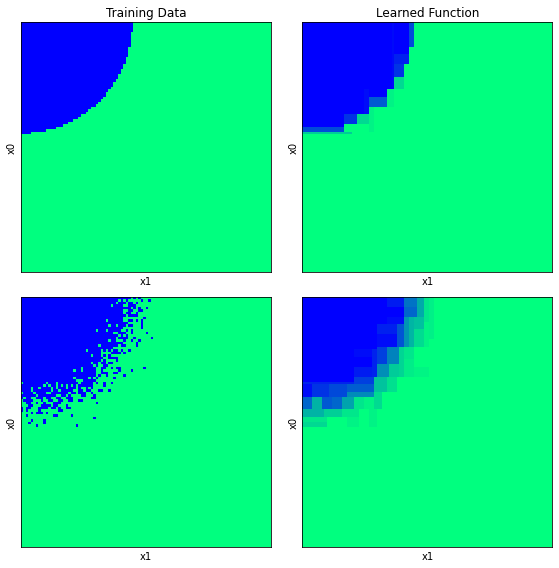

Tree with 66 leaves and depth of 10


In [53]:
from ibtree.datasets import circle_y


tree = DecisionTree(entropy, min_n=20)
X, y = circle_data()
tree.fit(X, y)
y_pred = tree.predict(X)

plt.figure(figsize=(8, 8))

plt.subplot(221)
plt.title("Training Data")
plot_on_grid(y[:, 0], 100)
plt.subplot(222)
plt.title("Learned Function")
y_pred = tree.predict(X)
plot_on_grid(y_pred[:, 0], 100)


y_train = circle_y(X + np.random.normal(0, 0.05, size=X.shape))
tree = DecisionTree(entropy, min_n=20)
tree.fit(X, y_train)

plt.subplot(223)
plot_on_grid(y_train[:,0], 100)

plt.subplot(224)
y_pred = tree.predict(X)       
plot_on_grid(y_pred[:, 0], 100)
plt.tight_layout()
plt.show()

print(f"Tree with {tree.n_leaves} leaves and depth of {tree.depth}")


## Growing a Tree

Now, we watch how the tree learns by letting it use an increasing maximal depth.

### Densely sampled (completely unrealistic, but interesting)

<Figure size 432x288 with 0 Axes>

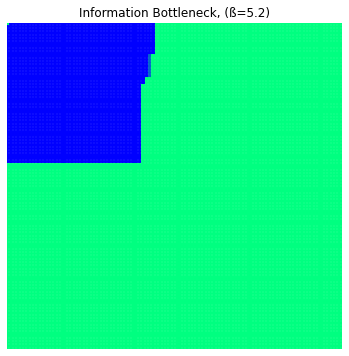

In [18]:
X, y = circle_data()
# tree = DecisionTree(entropy, min_n=2)
# animate_fitting(tree, X, y, "InformationGain (ß=infinity)")

# tree = DecisionTree(categorical_IB(beta=10), min_n=2)
# animate_fitting(tree, X, y, "Information Bottleneck, (ß=10)")

tree = DecisionTree(categorical_IB(beta=5.4), min_n=2)
animate_fitting(tree, X, y, "Information Bottleneck, (ß=5.4)")

# tree = DecisionTree(categorical_IB(beta=10), min_n=2,random_projections=20)
# animate_fitting(tree, X, y)

## Same, but X is randomly sampled (a bit closer to the real world)

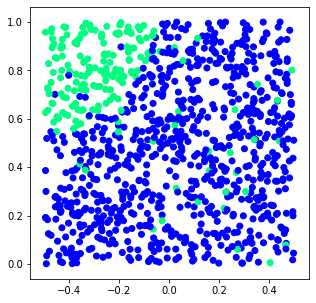

<Figure size 432x288 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

In [28]:
N = 1000
X = np.random.uniform(-0.5, 0.5, size=(N,2))
y = circle_y(X)
labelnoise = np.random.rand(N)>0.05
y[labelnoise] = 1-y[labelnoise]
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], 0.5-X[:,1], c=y[:,0], cmap='winter')
plt.show()

tree = DecisionTree(entropy)
animate_fitting(tree, X, y, "InformationGain (ß=infinity)")

tree = DecisionTree(categorical_IB(beta=15))
animate_fitting(tree, X, y, "Information Bottleneck, (ß=15)")

tree = DecisionTree(categorical_IB(beta=7))
animate_fitting(tree, X, y, "Information Bottleneck, (ß=7)")
plt.clf()


# Real world experiment

## Iris Flower Data

In [49]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
y=np.eye(3)[y]
X.shape,y.shape

iris = load_iris()
iris['feature_names'], f"X.shape={X.shape}", f"Y.shape={y.shape}"

(['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'],
 'X.shape=(150, 4)',
 'Y.shape=(150, 3)')

Let's see how well the tree generelizes if it can learn from 100 samples, and is testet on the other 50 samples.

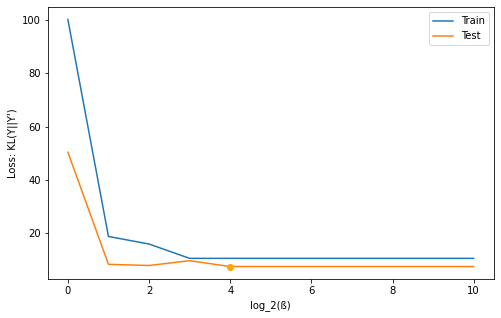

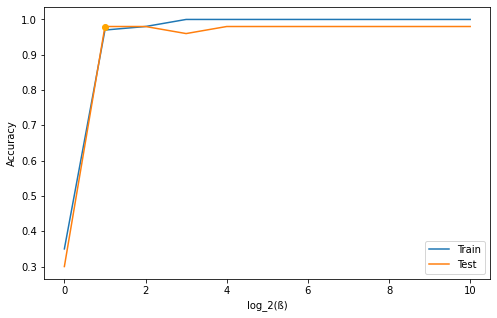

In [38]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

test_loss = []
test_acc = []
train_loss = []
train_acc = []


def get_metrics(y_true, y_pred,smooth=0.1):
    y_pred=y_pred*(1-2*smooth)+smooth
    kldiv = -np.sum(y_true*np.log(y_pred))
    acc = np.mean(y_true.argmax(1)==y_pred.argmax(1))
    return kldiv, acc

    
for log_beta in range(10):
    tree = DecisionTree(categorical_IB(beta=2**log_beta))
    tree.fit(X_train, y_train)
    y_train_pred = tree.predict(X_train)
    l, a = get_metrics(y_train, y_train_pred)
    train_loss.append(l)
    train_acc.append(a)
    
    y_test_pred = tree.predict(X_test)
    l, a = get_metrics(y_test, y_test_pred)
    test_loss.append(l)
    test_acc.append(a)
    

tree = DecisionTree(categorical_IB(beta=2**log_beta))
tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
l, a = get_metrics(y_train, y_train_pred)
train_loss.append(l)
train_acc.append(a)

y_test_pred = tree.predict(X_test)
l, a = get_metrics(y_test, y_test_pred)
test_loss.append(l)
test_acc.append(a)
    
plt.figure(figsize=(8,5))  
plt.plot(train_loss, label="Train")
plt.plot(test_loss, label="Test")
plt.plot([np.argmin(test_loss)],[min(test_loss)], 'o',color='orange')
plt.xlabel("log_2(ß)")
plt.ylabel("Loss: KL(Y||Y')")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))  
plt.plot(train_acc, label="Train")
plt.plot(test_acc, label="Test")
plt.plot([np.argmax(test_acc)],[max(test_acc)], 'o',color='orange')
plt.xlabel("log_2(ß)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

We see actually no indicator for overfitting on this dataset, butat least we see that it works! We can also check what it does:

In [46]:
tree = DecisionTree(categorical_IB(beta=2))
tree.fit(X_train, y_train)
print_tree(tree, iris['feature_names'])

 petal length (cm) <= 1.9 : 31 vs 69
  | >> M: [31.  0.  0.]
 petal length (cm) > 1.9
  | petal width (cm) <= 1.7 : 38 vs 31
  |  | petal length (cm) <= 5.1 : 36 vs 2
  |  |  | >> M: [ 0. 34.  2.]
  |  | petal length (cm) > 5.1
  |  |  | >> M: [0. 0. 2.]
  | petal width (cm) > 1.7
  |  | >> M: [ 0.  1. 30.]


## MNIST

Now, we try something slightly harder: MNIST.

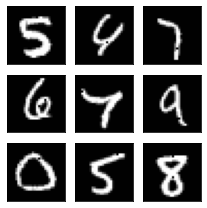

In [14]:
#!pip install tensorflow
from tensorflow.keras.datasets import mnist


def visualize_digits(X, Y=None):
    X = (X+1)/2
    X = X.reshape([-1, 28, 28])
    rows, cols = int(np.sqrt(len(X))), int(np.ceil(np.sqrt(len(X))))
    fig, axes = plt.subplots(nrows=rows, ncols=cols, squeeze=False,
                            figsize=(cols,rows,))
    for i, x in enumerate(X):
        row = int(i/cols)
        col = i % cols
        ax = axes[row][col]
        if Y is not None:
            y = Y[i]
            ax.set_title(np.argmax(y))
        ax.tick_params(
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            left=False,
            right=False,
            labelbottom=False,
            labelleft=False) # labels along the bottom edge are off
        ax.imshow(x, cmap='gray')
    plt.tight_layout()
    plt.show()
    
    

(X_train_raw, Y_train), (X_test_raw, Y_test) = mnist.load_data()
visualize_digits(X_test_raw[120:129])

First, we compress it to 27 dimensions using PCA, the digits are still more or less clearly recognizeable.

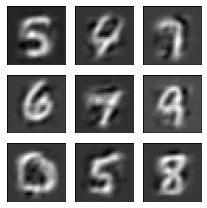

In [15]:
# run !pip install git+https://github.com/nielsrolf/pca.git
from pca import PCA
pca = PCA(X_train_raw[:1000])
X_train = pca.transform(X_train_raw, ndims=27)
X_test = pca.transform(X_test_raw, ndims=27)
visualize_digits(pca.inverse_transform(X_test[120:129]))

y_train = np.eye(10)[Y_train]
y_test = np.eye(10)[Y_test]


Test Acc 0.1135
Test Acc 0.7077
Test Acc 0.7553
Test Acc 0.7611
Test Acc 0.7586


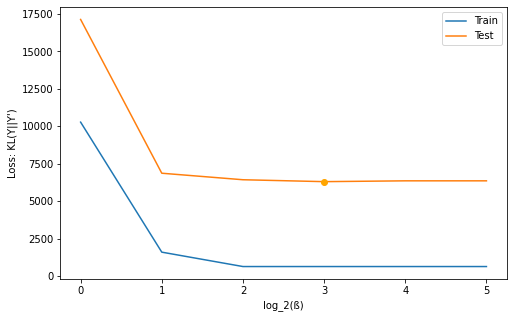

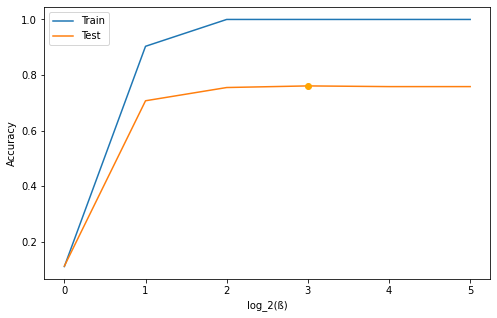

In [19]:
from sklearn.model_selection import train_test_split

X_train = X_train[:6000]
y_train = y_train[:6000]

test_loss = []
test_acc = []
train_loss = []
train_acc = []


def get_metrics(y_true, y_pred,smooth=0.1):
    y_pred=y_pred*(1-2*smooth)+smooth
    kldiv = -np.sum(y_true*np.log(y_pred))
    acc = np.mean(y_true.argmax(1)==y_pred.argmax(1))
    return kldiv, acc

    
for log_beta in range(0, 10, 2):
    tree = DecisionTree(categorical_IB(beta=2**log_beta))
    tree.fit(X_train, y_train)
    y_train_pred = tree.predict(X_train)
    l, a = get_metrics(y_train, y_train_pred)
    train_loss.append(l)
    train_acc.append(a)
    
    y_test_pred = tree.predict(X_test)
    l, a = get_metrics(y_test, y_test_pred)
    print("Test Acc", a)
    test_loss.append(l)
    test_acc.append(a)
    

tree = DecisionTree(categorical_IB(beta=2**log_beta))
tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
l, a = get_metrics(y_train, y_train_pred)
train_loss.append(l)
train_acc.append(a)

y_test_pred = tree.predict(X_test)
l, a = get_metrics(y_test, y_test_pred)
test_loss.append(l)
test_acc.append(a)
    
plt.figure(figsize=(8,5))  
plt.plot(train_loss, label="Train")
plt.plot(test_loss, label="Test")
plt.plot([np.argmin(test_loss)],[min(test_loss)], 'o',color='orange')
plt.xlabel("log_2(ß)")
plt.ylabel("Loss: KL(Y||Y')")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))  
plt.plot(train_acc, label="Train")
plt.plot(test_acc, label="Test")
plt.plot([np.argmax(test_acc)],[max(test_acc)], 'o',color='orange')
plt.xlabel("log_2(ß)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

We trained only on 10% of the regular train set, and got the best generalization accuracy with $\beta=64$ - but not with pure entropy as loss.

As a comparison, let's see how the default sklearn decision tree performs - which uses the gini impurity as loss function.

In [37]:
from sklearn import tree as sklearntree

gini_tree = sklearntree.DecisionTreeClassifier()
gini_tree.fit(X_train, y_train)
y_test_pred = gini_tree.predict(X_test)
np.mean(y_test_pred.argmax(1) == y_test.argmax(1))

0.7542

Wow - so this hand made solution might actually be useful, it beats the default sklearn implementation in terms of test accuracy! However, the sklearn implementation has of course a lot more tunable hyperparameters and runs much faster. But for a proof-of-concept, this is quite a satisfying result.